In [35]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

## I - data loading

In [6]:
data = np.load("../datasets/CIFAR10/CIFAR-10.npy")

In [42]:
indices = np.random.permutation(len(data))
train_idx, val_idx, test_idx = np.split(indices, [int(round(len(indices)*i)) for i in (0.8, 0.9)])
train, val, test = data[train_idx], data[val_idx], data[test_idx]

(-0.5, 31.5, 31.5, -0.5)

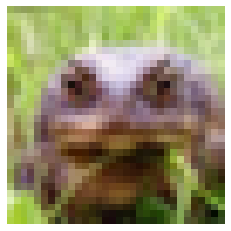

In [32]:
f, ax = plt.subplots()
ax.imshow(data[np.random.randint(len(data))].transpose(1, 2, 0))
ax.axis("off")

## II - Model definition

In [76]:
class Encoder(torch.nn.Module):

    def __init__(self, channels: list[int]):
        super().__init__()
        in_channels = 3
        self.linears = torch.nn.ModuleList()
        self.activated = torch.nn.ModuleList()
        self.batch_norms = torch.nn.ModuleList()
        self.max_pooling = torch.nn.MaxPool2d((2, 2))
        self.mean_pooling = torch.nn.AvgPool2d((2, 2))
        self.activation = F.relu
        kwargs = {"kernel_size": (3, 3), "stride": (1, 1), "padding": (1, 1)}
        for out_channels in channels:
            self.linears.append(torch.nn.Conv2d(in_channels, out_channels, **kwargs))
            self.activated.append(torch.nn.Conv2d(in_channels, out_channels, **kwargs))
            self.batch_norms.append(torch.nn.BatchNorm2d(out_channels))
            in_channels = out_channels
    
    def forward(self, X):
        for linear, activ, bn in zip(self.linears, self.activated, self.batch_norms):
            X = bn(self.max_pooling(self.activation(activ(X))) + self.mean_pooling(linear(X)))
        return X
        

class Decoder(torch.nn.Module):
    
    def __init__(self, channels: list[int]):
        super().__init__()
        in_channels = channels[-1]
        print(in_channels, channels[-2::-1]+[3])
        self.linears = torch.nn.ModuleList()
        self.activated = torch.nn.ModuleList()
        self.batch_norms = torch.nn.ModuleList()
        self.activation = F.relu
        kwargs = {"kernel_size": (3, 3), "stride": (1, 1), "padding": (1, 1)}
        for out_channels in channels[-2::-1]+[3]:
            self.linears.append(torch.nn.Conv2d(in_channels, out_channels, **kwargs))
            self.activated.append(torch.nn.Conv2d(in_channels, out_channels, **kwargs))
            self.batch_norms.append(torch.nn.BatchNorm2d(out_channels))
            in_channels = out_channels
    
    def forward(self, X):
        for linear, activ, bn in zip(self.linears, self.activated, self.batch_norms):
            X = F.interpolate(X, scale_factor=2, mode="bilinear", align_corners=True)
            X = bn(self.activation(activ(X)) + linear(X))
        return X


class Model(torch.nn.Module):

    def __init__(self, channels: list[int]):
        super().__init__()
        self.encoder = Encoder(channels)
        self.decoder = Decoder(channels)
    
    def forward(self, X):
        return self.decoder(self.encoder(X))
    
    def to_tensor(self, array: np.ndarray) -> torch.Tensor:
        return torch.tensor(array, dtype=torch.float32, device=self.device) / 255.
    
    def encode(self, array: np.ndarray) -> np.ndarray:
        self.eval()
        with torch.no_grad():
            return self.encoder(self.to_tensor(array)).detach().cpu().numpy()
    
    def decode(self, array: np.ndarray) -> np.ndarray:
        self.eval()
        with torch.no_grad():
            X = torch.tensor(array, dtype=torch.float32, device=self.device)
            return self.decoder(X).detach().cpu().numpy()

    @property
    def device(self):
        return self.encoder.linears[0].weight.device

In [79]:
def batches(array: np.ndarray, batch_size: int, n_batches: int):
    """
    yield "n_batches" batches of size "batche_size"
    """
    indices = np.random.permutation(len(array))
    for i in range(n_batches):
        yield array[indices[i*batch_size:(i+1)*batch_size]]

def train_loop(model: Model, optimizer: torch.optim.Optimizer, train_data: np.ndarray, val_data: np.ndarray, n_steps: int = 1000, n_batches: int = 5, batch_size: int = 100):
    """
    train the model for "n_steps" steps
    """
    try:
        for step in range(n_steps):
            optimizer.zero_grad()
            # train loss
            losses = []
            model.train()
            for array in batches(train_data, batch_size, n_batches):
                X = model.to_tensor(array)
                loss = F.mse_loss(model(X), X)
                loss.backward()
                losses.append(loss.item())
            train_loss = sum(losses) / max(1, len(losses))
            # val loss
            losses = []
            model.eval()
            with torch.no_grad():
                for array in batches(val_data, batch_size, n_batches):
                    X = model.to_tensor(array)
                    losses.append(F.mse_loss(model(X), X).item())
            val_loss = sum(losses) / max(1, len(losses))
            # step and display
            optimizer.step()
            print(f"Step {step}: train loss = {train_loss:.3g} val loss = {val_loss:.3g}")
    except KeyboardInterrupt:
        pass


In [82]:
model = Model([8, 16, 32])
model.to("cuda:0")
train_loop(model, torch.optim.Adam(model.parameters()), train, val, batch_size=1000, n_batches=1)

32 [16, 8, 3]
Step 0: train loss = 1.33 val loss = 0.307
Step 1: train loss = 1.03 val loss = 0.164
Step 2: train loss = 0.975 val loss = 0.0948
Step 3: train loss = 0.952 val loss = 0.0722
Step 4: train loss = 0.937 val loss = 0.077
Step 5: train loss = 0.929 val loss = 0.0952
Step 6: train loss = 0.927 val loss = 0.109
Step 7: train loss = 0.918 val loss = 0.119
Step 8: train loss = 0.902 val loss = 0.124
Step 9: train loss = 0.897 val loss = 0.129
Step 10: train loss = 0.895 val loss = 0.13
Step 11: train loss = 0.899 val loss = 0.139
Step 12: train loss = 0.89 val loss = 0.152
Step 13: train loss = 0.879 val loss = 0.168
Step 14: train loss = 0.882 val loss = 0.178
Step 15: train loss = 0.881 val loss = 0.209
Step 16: train loss = 0.868 val loss = 0.227
Step 17: train loss = 0.872 val loss = 0.245
Step 18: train loss = 0.861 val loss = 0.281
Step 19: train loss = 0.862 val loss = 0.292
Step 20: train loss = 0.846 val loss = 0.312
Step 21: train loss = 0.857 val loss = 0.337
Step 22

In [ ]:
X = model.to_tensor(train[:10])

In [73]:
model.decoder(model.encoder(X)).shape

RuntimeError: The size of tensor a (16) must match the size of tensor b (32) at non-singleton dimension 1

In [74]:
model.decoder.activated

ModuleList(
  (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(8, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [75]:
model.encoder.activated

ModuleList(
  (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [57]:
[8, 16, 32][-2::-1] + [3]

[16, 8, 3]